# Deep Q-Learning Project 1


In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import namedtuple, deque


import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

import pickle
import matplotlib.pyplot as plt
import os

import time
import pdb

from matplotlib import colors
from IPython.display import display, clear_output


%matplotlib notebook

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

In [2]:
path= "C:\\Users\\mbgpcsk4\\Dropbox (The University of Manchester)\\D2019\\University\\Udacity\\deep-reinforcement-learning\\p1_navigation\\Banana_Windows_x86_64\\Banana.exe"
env = UnityEnvironment(file_name=path)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of actions
action_size = brain.vector_action_space_size


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_layers = (64,32), drop_p = 0.1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], action_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        


    def forward(self, x):
        """Build a network that maps state -> action values."""
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        return self.output(x)
 


# Agent Class
This class acts is the agent which is initialised at the beginning of each experiment



In [4]:

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, LR = 5e-4, drop_p = 0.1, gamma = 0.99, priority_scale = 1.0, plotting = False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.layers = 2
        self.gamma = gamma
        self.tau = 0.1
        self.batch_size = 64
        self.buffer_size = int(1e5)
        self.update_every = 4
        self.priority_scale = priority_scale

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        
        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
        
        # Sets up the plots for the weigts of the NN
        if plotting:
        
            self.fig = plt.figure(figsize=(20,10))

            self.axs=[]
            for i in range(1,self.layers+2):
                self.axs.append(self.fig.add_subplot(1,self.layers+1, i))

            self.start_weight = []
            for layer in self.qnetwork_local.hidden_layers:
                self.start_weight.append(layer.weight.cpu().detach().numpy())

            self.start_weight.append(self.qnetwork_local.output.weight.cpu().detach().numpy())

            
            
    
    def step(self, state, action, reward, next_state, done):

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                self.learn()
       

    def act(self, state, eps=1):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        (states, actions, rewards, next_states, dones), importance, indices =\
        self.memory.sample(priority_scale=self.priority_scale)
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        errors = (Q_targets-Q_expected).cpu().detach().numpy()
        self.memory.set_priorities(indices, errors)

        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)                     

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
            
            
            
    def visualize(self, colorbar=False):
        """
        Visualize weights of all layers
        
        """
        
        i=0;
        images = []
        for layer in self.qnetwork_local.hidden_layers:
            self.axs[i].clear()
            weights = layer.weight.cpu().detach().numpy()
            images.append(self.axs[i].imshow((weights-self.start_weight[i])**2))
            i+=1
            
        self.axs[-1].clear()    
        weights = self.qnetwork_local.output.weight.cpu().detach().numpy()
        images.append(self.axs[-1].imshow((weights-self.start_weight[-1])**2))
       
        if colorbar:
            self.fig.colorbar(images[0], ax=self.axs, orientation='vertical')

        clear_output(wait = True)

        display(self.fig)


In [14]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(max(self.priorities,default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = pow(np.array(self.priorities), priority_scale)
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.memory) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
    
    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e[0]) + offset
            

    
    def sample(self, priority_scale):
        """Randomly sample a batch of experiences from memory."""
        # Get the probabilities that an experience should be sampled P(i)
        
        sample_probs = self.get_probabilities(priority_scale) # This is the problematic line
        
        
        # Get the indicies of the samples selected, the number os samples k, using probabilities weights.
        sample_indices = random.choices(range(len(self.memory)), k = self.batch_size, weights = sample_probs)

        # Make an array of all the selected experiences
        experiences = []
        [experiences.append(self.memory[i]) for i in sample_indices]
        
        importance = self.get_importance(sample_probs[sample_indices])
        
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones), importance, sample_indices

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [15]:
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, plotting = False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        start = time.time()
    
        for t in range(max_t):
            action = np.int32(agent.act(state,eps))            # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            
            if done:                                       # exit loop if episode finished
                #print('\n' + str(len(agent.memory.memory)))
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        print(f"\tTime per episode: {(time.time() - start)/3:.3f} seconds",end="")
        start = time.time()
        
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if plotting == True:
            agent.visualize()

    return scores

In [16]:
scores = []
agent = Agent(state_size=37, action_size=4, seed=0 )
scores.append(dqn(n_episodes=1000, agent = agent))

Episode 33	Average Score: 0.06	Time per episode: 0.505 secondss

KeyboardInterrupt: 

In [7]:
import cProfile
agent = Agent(state_size=37, action_size=4, seed=0)
cProfile.run('dqn(agent)')

Episode 45	Average Score: 0.11	Time per episode: 0.476 seconds 	Eps: 0.80         13014264 function calls (12674027 primitive calls) in 50.776 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    20420    0.251    0.000    3.856    0.000 <ipython-input-3-bfcd169098ed>:29(forward)
     3392    0.279    0.000    0.619    0.000 <ipython-input-4-f6500917a8c2>:119(soft_update)
    13636    0.219    0.000   24.017    0.002 <ipython-input-4-f6500917a8c2>:54(step)
    13636    0.193    0.000    3.398    0.000 <ipython-input-4-f6500917a8c2>:67(act)
     3393    0.200    0.000   19.421    0.006 <ipython-input-4-f6500917a8c2>:87(learn)
    13636    0.045    0.000    4.366    0.000 <ipython-input-5-094b714f07e8>:21(add)
     3393    0.087    0.000    5.241    0.002 <ipython-input-5-094b714f07e8>:29(get_probabilities)
     3392    0.034    0.000    0.062    0.000 <ipython-input-5-094b714f07e8>:34(get_importance)
     3392    0.739    0.0

KeyboardInterrupt: 

In [11]:
env.close()

In [12]:
help(random.choice)

Help on method choice in module random:

choice(seq) method of random.Random instance
    Choose a random element from a non-empty sequence.



In [32]:
def experiment(state_size=37, action_size=4, seed=0, parameter = None, experiment_variables=None, \
               hyper_parameters = None, episodes = 100, experiment_name = None, plotting = True, drop_p = 0, gamma = 0.99):
    scores = []
    if hyper_parameters == None:
        for i in range(len(experiment_variables)):
            print('Starting Experiment Variable: '+ str(experiment_variables[i]))
            agent = Agent(state_size=37, action_size=4, seed=0, experiment_variable = experiment_variables[i], \
                          drop_p = drop_p, gamma = gamma)
            scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
            agent.visualize(colorbar=True)
            plt.savefig(cwd+'\\Data\\' +experiment_name+'_Weights_'+str(experiment_variables[i])+'.png')
            f = open(cwd+'\\Data\\'  + experiment_name+'scores.pckl', 'wb')
            pickle.dump(scores, f)
            f.close() 
            f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
            pickle.dump(experiment_variables[:i+1], f)
            f.close() 
        
    if experiment_variables == None:
        if parameter == 'LR':
            for i in range(len(hyper_parameters)):
                print('Starting Learning Rate Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, experiment_variable = (32,), LR = hyper_parameters[i] )
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                agent.visualize(colorbar=True)
                plt.savefig(cwd+'\\Data\\' +experiment_name+'_Weights_'+str(hyper_parameters[i])+'.png')
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 
                
        if parameter == 'dropout':
            for i in range(len(hyper_parameters)):
                print('Starting Dropout Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, experiment_variable = (32,), drop_p = hyper_parameters[i] )
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                agent.visualize(colorbar=True)
                plt.savefig(cwd+'\\Data\\' +experiment_name+'_Weights_'+str(hyper_parameters[i])+'.png')
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 
                
        if parameter == 'gamma':
            for i in range(len(hyper_parameters)):
                print('Starting Gamma Variable: '+ str(hyper_parameters[i]))
                agent = Agent(state_size=37, action_size=4, seed=0, experiment_variable = (32,), drop_p = drop_p, gamma = hyper_parameters[i] )
                scores.append(dqn(n_episodes=episodes, agent = agent, plotting = plotting))
                agent.visualize(colorbar=True)
                plt.savefig(cwd+'\\Data\\' +experiment_name+'_Weights_'+str(hyper_parameters[i])+'.png')
                f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'wb')
                pickle.dump(scores, f)
                f.close() 
                f = open(cwd+'\\Data\\'  +experiment_name+'variable.pckl', 'wb')
                pickle.dump(hyper_parameters[:i+1], f)
                f.close() 

In [33]:

def plotExp(experiment_name):
    f = open(cwd+'\\Data\\'  +experiment_name+'scores.pckl', 'rb')
    scores = pickle.load(f)
    f.close() 

    f = open(cwd+'\\Data\\' +experiment_name+'variable.pckl', 'rb')
    fc = pickle.load(f)
    f.close() 

    window = np.int32(np.rint(0.05*len(scores[0])))
    running_scores=[]
    for ep in scores:
        running_scores.append(np.convolve(ep, np.ones((window,))/window, mode='valid'))

    for ep in range(len(fc)):
        plt.plot(np.arange(len(running_scores[ep])), running_scores[ep], label=fc[ep])
    plt.legend() 
    plt.savefig(cwd+'\\Data\\' +experiment_name+'.png')
    plt.show()
    

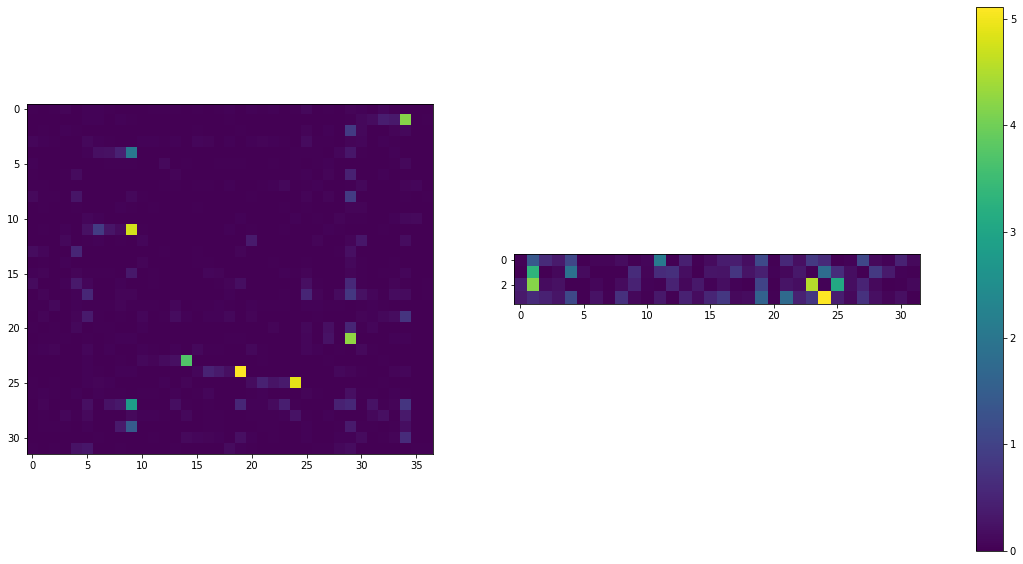

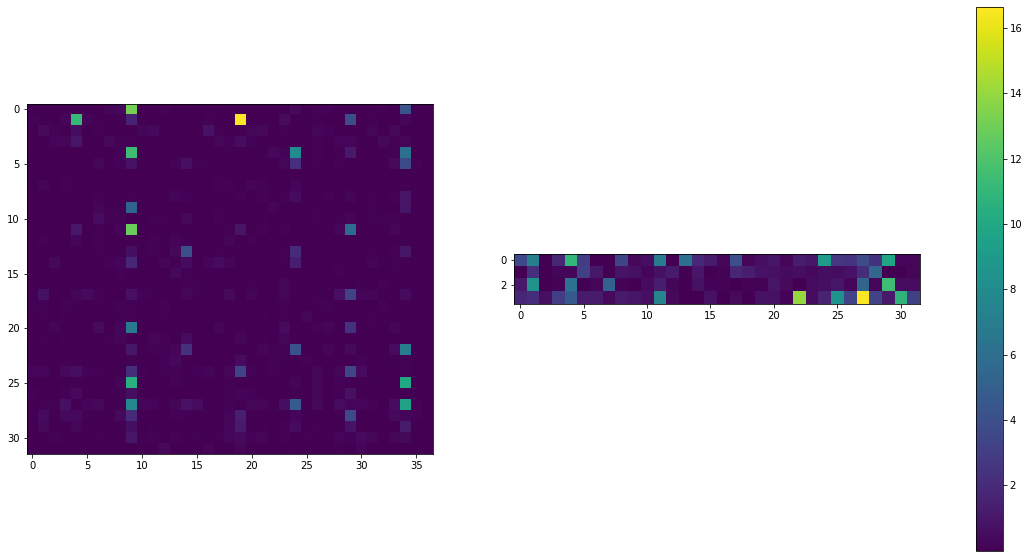

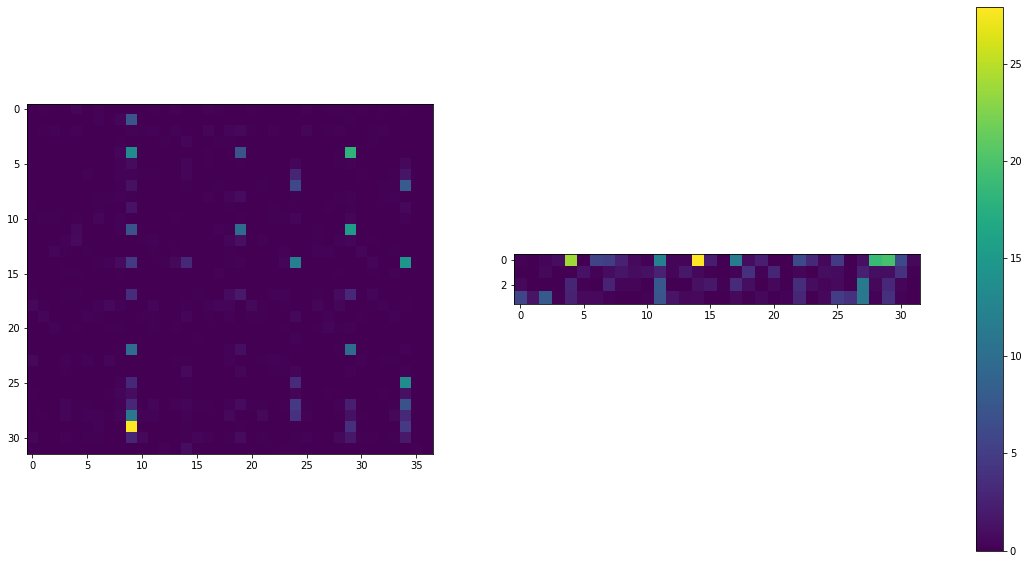

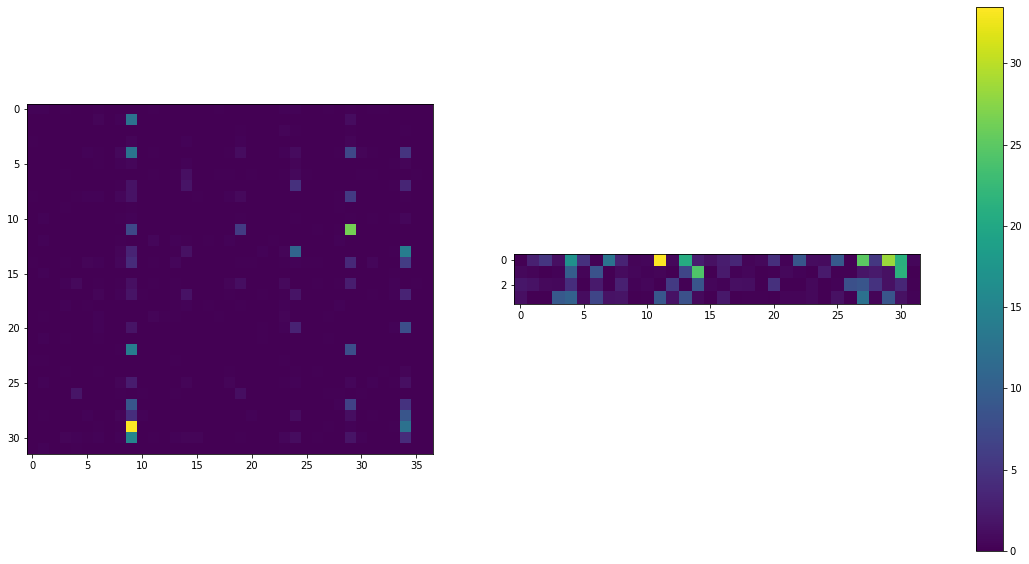

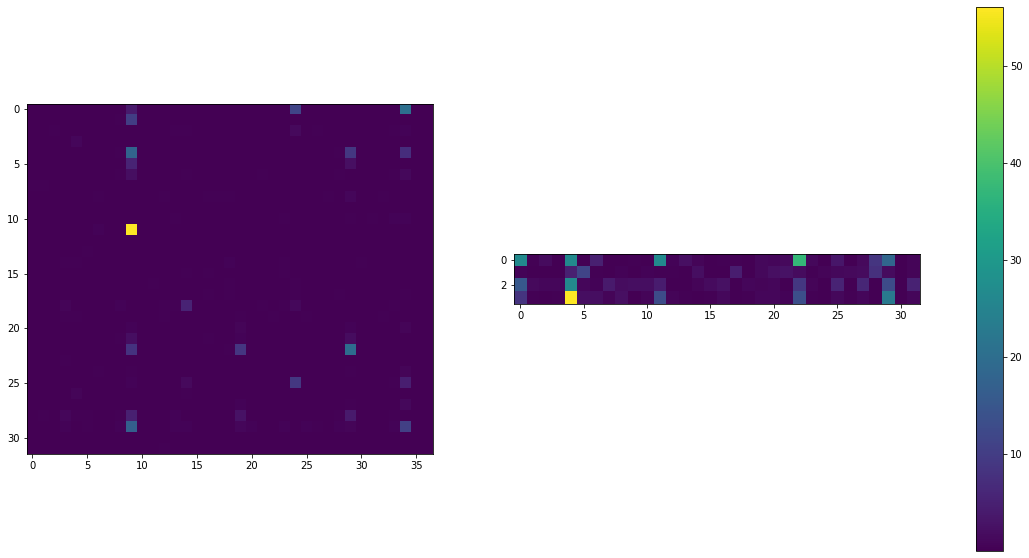

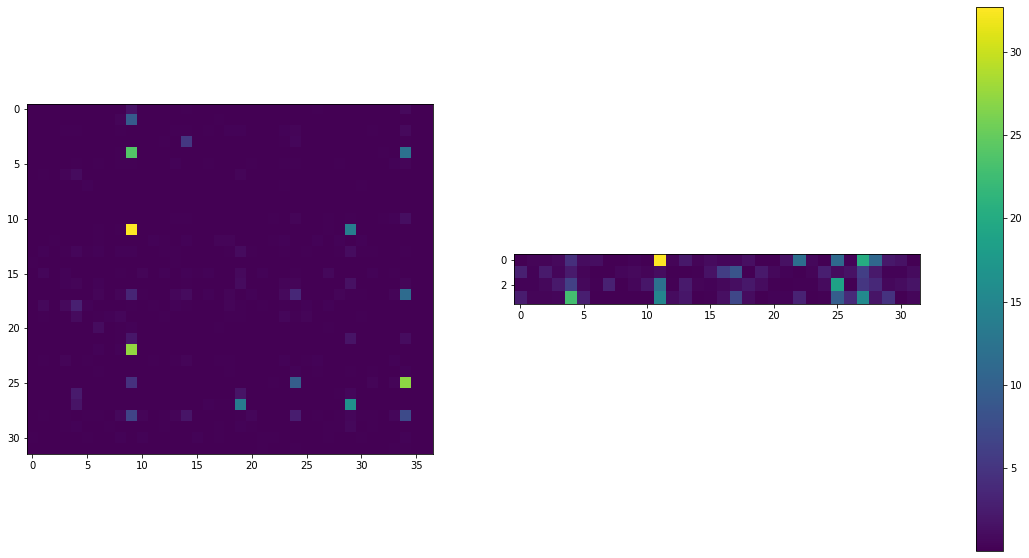

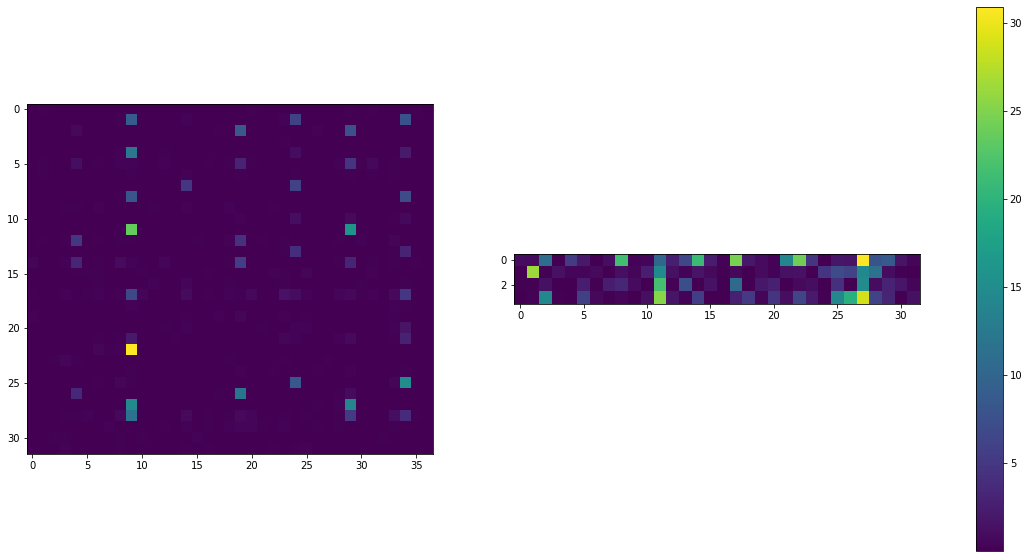

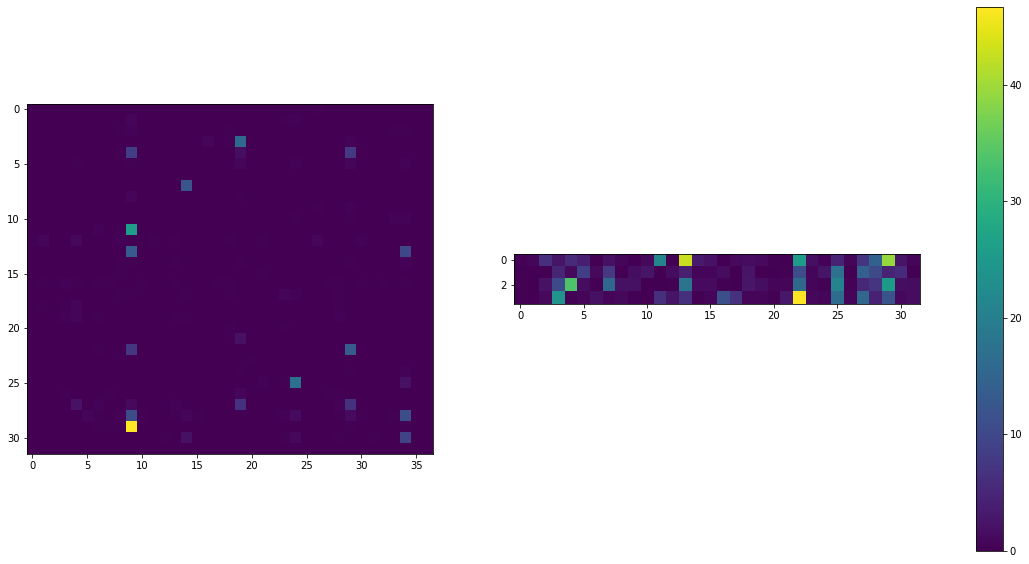

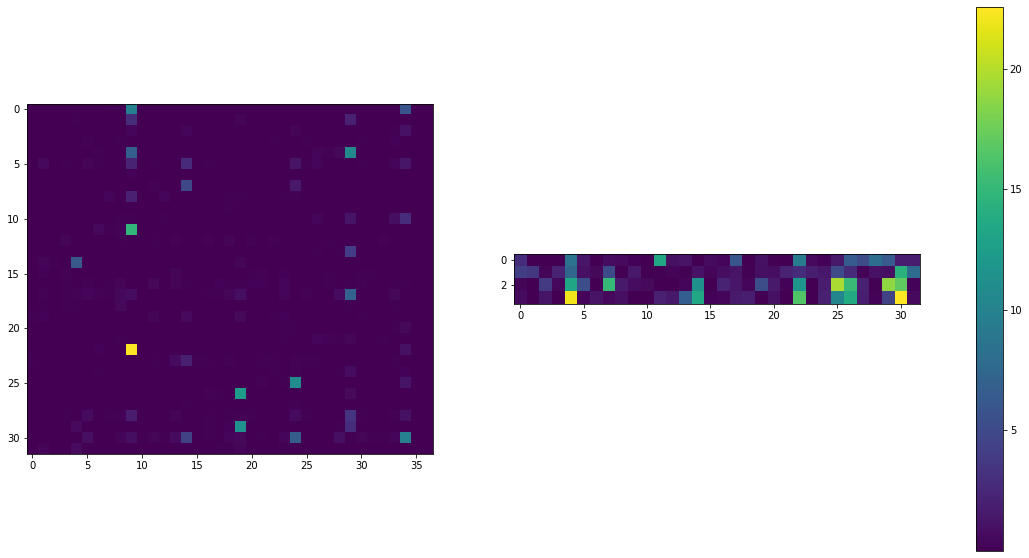

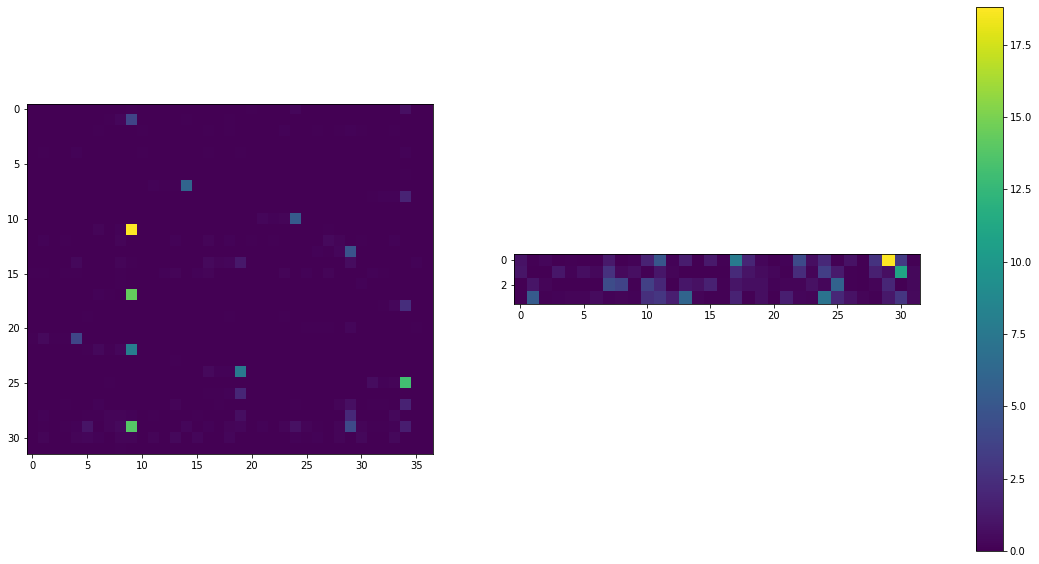

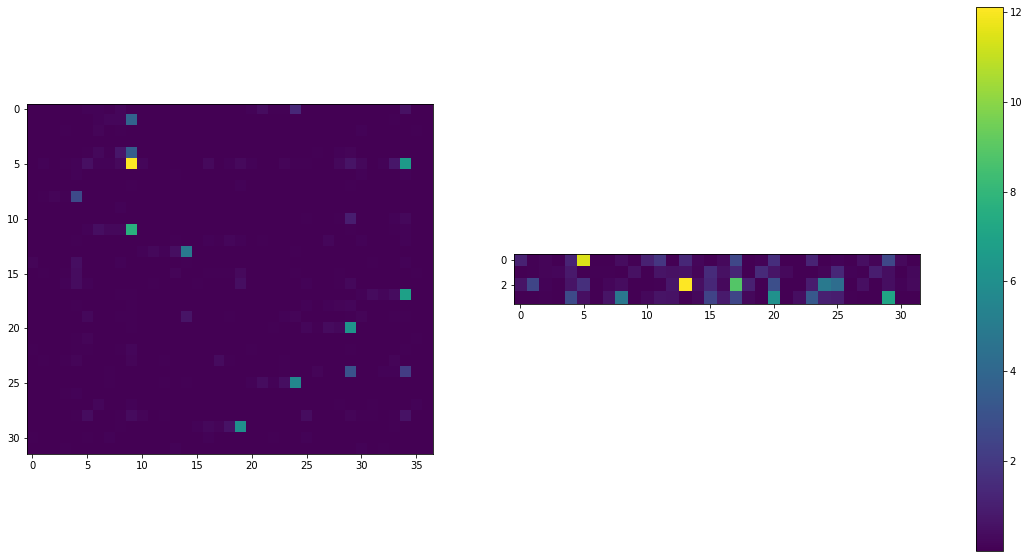

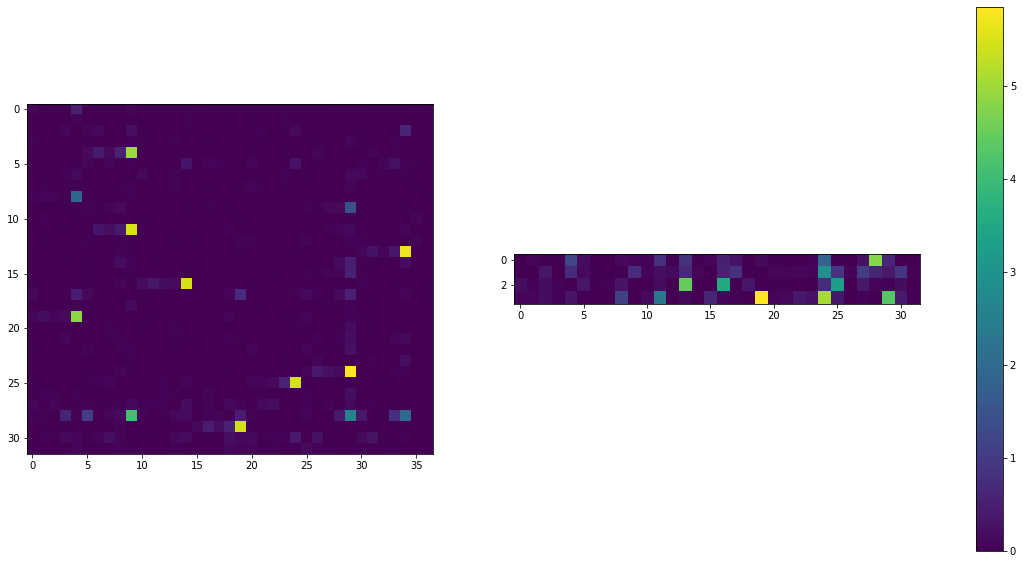

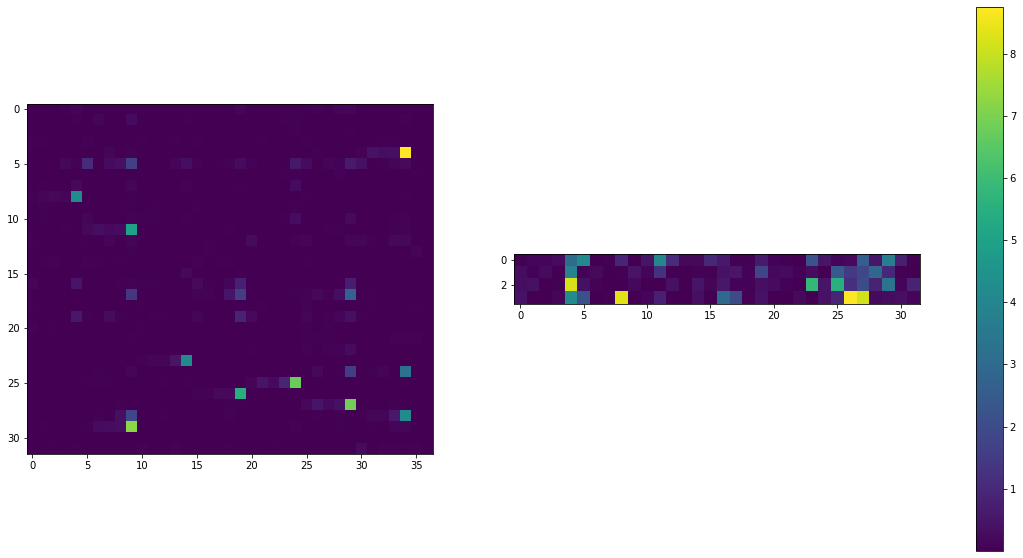

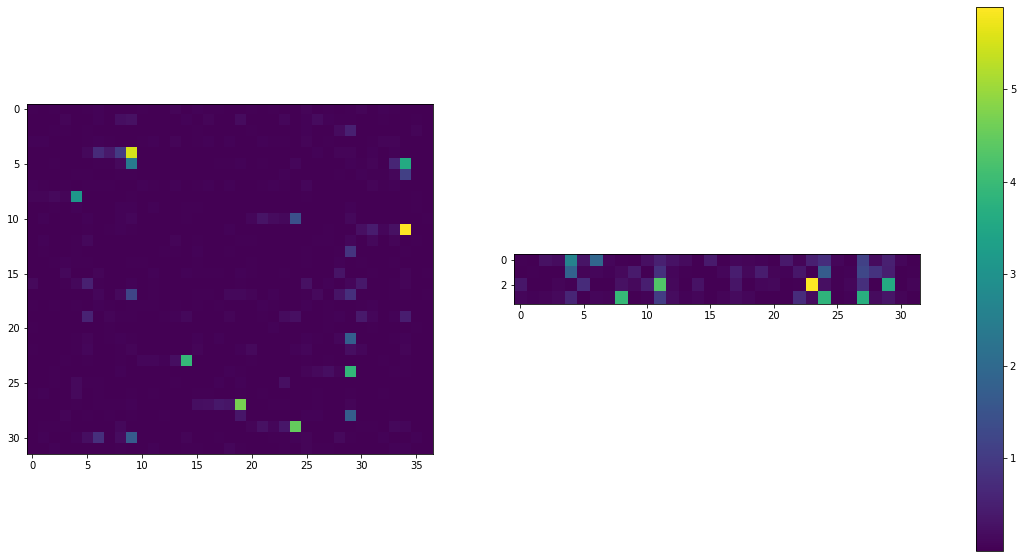

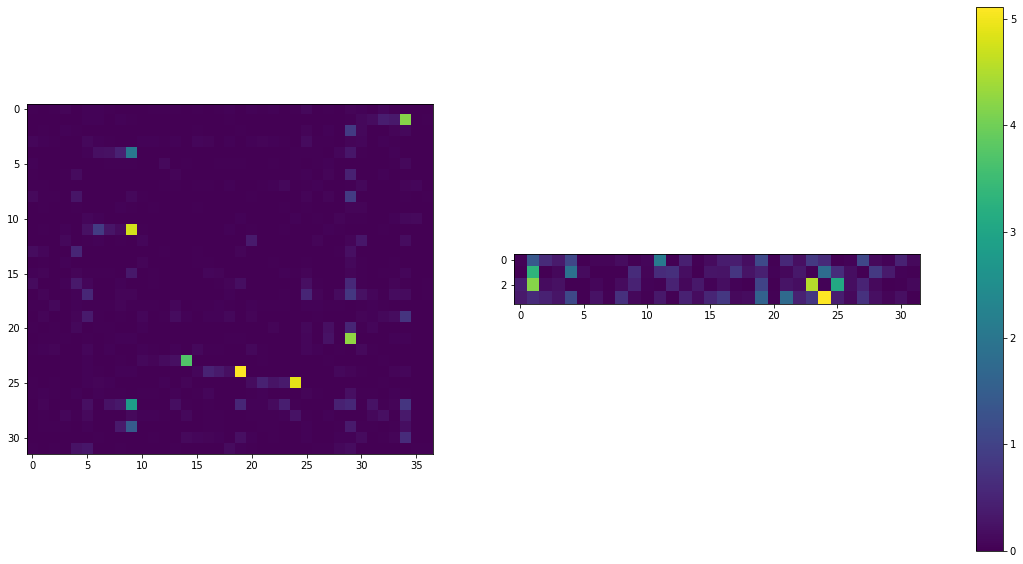

In [7]:
gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.98, 0.99]
exname = 'gammaSingleLayerDO0'
experiment(experiment_variables=None, parameter = 'gamma', hyper_parameters = gamma,\
           episodes = 1000, experiment_name = exname ,plotting = False, drop_p = 0, gamma = None)

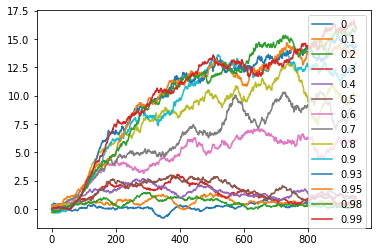

In [8]:
plotExp(exname)